# EECE5644 Assignment 3 - Question 2

## Description
Implementation of Gaussian Mixture Model (GMM) order selection using 10-fold cross-validation with the EM algorithm. Evaluates GMM candidate models (1-10 components) on datasets of varying sizes (10, 100, 1000 samples) through 100+ experimental trials to analyze model selection behavior.

## Table of Contents
1. Setup & Imports
2. Helper Functions
3. GMM Model Training & Evaluation
4. Experiment Pipeline

## 1. Setup & Imports

Import required libraries and set random seeds for reproducibility.

### Contents
- 1.1 Imports  
- 1.2 Random Seed

In [ ]:
# @title 1.1 Imports

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# @title 1.2 Random Seed

np.random.seed(42)

## 2. Helper Functions

Utility functions for generating GMM data and computing log-likelihood for model evaluation.

### Contents
- 2.1 Data Generation Function  
- 2.2 Log-Likelihood Computation Function

In [ ]:
# @title 2.1 Data Generation Function

def generate_gmm_data(
  n: int,
  means: np.ndarray,
  covs: np.ndarray,
  weights: np.ndarray
) -> np.ndarray:
  """
  Generate n samples from a Gaussian Mixture Model.

  Args:
    n: Number of samples to generate.
    means: (k, 2) array of component means.
    covs: (k, 2, 2) array of component covariance matrices.
    weights: (k,) array of component mixing weights (should sum to 1).

  Returns:
    x: (n, 2) array of generated data samples.
  """
  num_components = len(weights)
  dim = means.shape[1]

  x = np.zeros((n, dim))

  for i in range(n):
    # select component according to weights
    component = np.random.choice(num_components, p=weights)

    # generate sample from selected component
    x[i] = np.random.multivariate_normal(means[component], covs[component])

  return x

In [ ]:
# @title 2.2 Log-Likelihood Computation Function

def compute_log_likelihood(
  gmm: GaussianMixture,
  x: np.ndarray
) -> float:
  """
  Compute the log-likelihood of data under a fitted GMM.

  Args:
    gmm: Fitted GaussianMixture model.
    x: (n, 2) array of data samples.

  Returns:
    log_likelihood: Average log-likelihood per sample.
  """
  return gmm.score(x)

## 3. GMM Model Training & Evaluation

Functions for training GMM models using EM algorithm and performing cross-validation for model order selection.

### Contents
- 3.1 GMM Training Function  
- 3.2 Cross-Validation Function

In [ ]:
# @title 3.1 GMM Training Function

def train_gmm(
  x: np.ndarray,
  n_components: int,
  max_iter: int = 200,
  n_init: int = 10,
  random_state: int = None
) -> GaussianMixture:
  """
  Train a Gaussian Mixture Model using EM algorithm.

  Args:
    x: Training data.
    n_components: Number of Gaussian components.
    max_iter: Maximum number of EM iterations.
    n_init: Number of random initializations.
    random_state: Random seed for reproducibility.

  Returns:
    gmm: Fitted GaussianMixture model.
  """
  gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='full',
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state
  )

  gmm.fit(x)

  return gmm

In [ ]:
# @title 3.2 Cross-Validation Function

def cross_validate_gmm(
  x: np.ndarray,
  component_candidates: list[int],
  k_folds: int = 10,
  max_iter: int = 200,
  n_init: int = 10
) -> tuple[int, np.ndarray]:
  """
  Perform k-fold cross-validation to select best number of GMM components.
  Uses log-likelihood as the objective function.

  Args:
    x: Training data.
    component_candidates: List of component counts to try.
    k_folds: Number of cross-validation folds.
    max_iter: Maximum EM iterations per model.
    n_init: Number of random initializations per model.

  Returns:
    best_k: Optimal number of components.
    mean_cv_log_likelihoods: Average CV log-likelihood for each K value.
  """
  # adjust k_folds if dataset is too small
  n_samples = x.shape[0]
  max_components = max(component_candidates)
  adjusted_k_folds = min(k_folds, n_samples // (max_components + 1))
  adjusted_k_folds = max(2, adjusted_k_folds)
  if adjusted_k_folds < k_folds:
    print(f"    (Using {adjusted_k_folds}-fold CV due to small dataset size)")

  mean_cv_log_likelihoods = []

  print(f"    Testing {len(component_candidates)} component values...")

  # define kfold
  kf = KFold(n_splits=adjusted_k_folds, shuffle=True, random_state=42)

  for k in component_candidates:
    fold_log_likelihoods = []
    print(f"      K={k:2d}: ", end='', flush=True)

    for train_idx, val_idx in kf.split(x):
      x_train, x_val = x[train_idx], x[val_idx]

      # skip if not enough samples for this k
      if x_train.shape[0] < k:
        print('s', end='', flush=True)
        continue

      # train GMM
      try:
        gmm = train_gmm(
          x_train,
          n_components=k,
          max_iter=max_iter,
          n_init=n_init,
          random_state=42
        )

        # evaluate on validation set
        log_likelihood = compute_log_likelihood(gmm, x_val)
        fold_log_likelihoods.append(log_likelihood)

        print('.', end='', flush=True)
      except:
        print('x', end='', flush=True)
        continue

    if len(fold_log_likelihoods) > 0:
      mean_ll = np.mean(fold_log_likelihoods)
      mean_cv_log_likelihoods.append(mean_ll)
      print(f' Avg Log-Likelihood={mean_ll:.4f}')
    else:
      # no valid folds
      mean_cv_log_likelihoods.append(-np.inf)
      print(f' No valid folds (insufficient data)')

  # select K with maximum log-likelihood
  valid_indices = [i for i, ll in enumerate(mean_cv_log_likelihoods) if ll != -np.inf]

  if len(valid_indices) > 0:
    best_idx = valid_indices[np.argmax([mean_cv_log_likelihoods[i] for i in valid_indices])]
    best_k = component_candidates[best_idx]
  else:
    # fallback
    best_k = component_candidates[0]

  return best_k, np.array(mean_cv_log_likelihoods)

## 4. Experiment Pipeline

This section executes the complete experimental procedure including true GMM definition,
repeated data generation, cross-validation-based model selection, and statistical
analysis of model selection results across multiple trials.

### Contents
- 4.1 Configuration
- 4.2 Multiple Trial Experiments
- 4.3 Results Analysis
- 4.4 Visualization

In [ ]:
# @title 4.1 Configuration

# means
means = np.array([
  [0, 0],
  [2, 2],
  [6, 0],
  [0, 6]
])

# covariance matrices
cov1 = np.array([[1.5, 0.3], [0.3, 1.5]])
cov2 = np.array([[1.5, -0.3], [-0.3, 1.5]])
cov3 = np.array([[1.0, 0.0], [0.0, 1.0]])
cov4 = np.array([[1.0, 0.0], [0.0, 1.0]])
covs = np.array([cov1, cov2, cov3, cov4])

# weights
weights = np.array([0.25, 0.25, 0.25, 0.25])

print("True GMM Configuration:")
print(f"  - Number of components: {len(weights)}")
print(f"  - Dimension: {means.shape[1]}D")
print(f"  - Components 1 and 2 overlap significantly")
print(f"  - Mixing weights: {weights}")

True GMM Configuration:
  - Number of components: 4
  - Dimension: 2D
  - Components 1 and 2 overlap significantly
  - Mixing weights: [0.25 0.25 0.25 0.25]


In [ ]:
# @title 4.2 Multiple Trial Experiments

# parameters
dataset_sizes = [10, 100, 1000]
component_candidates = list(range(1, 11))
k_folds = 10
n_trials = 100
max_iter = 200
n_init = 10

# results
selection_counts = {n: np.zeros(len(component_candidates)) for n in dataset_sizes}
cumulative_log_likelihoods = {n: np.zeros(len(component_candidates)) for n in dataset_sizes}

print(f"\nConfiguration:")
print(f"  - Dataset sizes: {dataset_sizes}")
print(f"  - Component candidates: {component_candidates[0]}-{component_candidates[-1]}")
print(f"  - Number of trials: {n_trials}")
print(f"  - CV folds: {k_folds}")

for n in dataset_sizes:
  print(f"\n{'='*70}")
  print(f"Dataset size N={n} samples")
  print(f"{'='*70}")

  for trial in range(n_trials):
    if (trial + 1) % 10 == 0:
      print(f"  Trial {trial + 1}/{n_trials}...")

    # generate dataset
    x = generate_gmm_data(n, means, covs, weights)

    # cross-validation
    best_k, cv_log_likelihoods = cross_validate_gmm(
      x,
      component_candidates,
      k_folds=k_folds,
      max_iter=max_iter,
      n_init=n_init
    )

    # record
    best_k_idx = component_candidates.index(best_k)
    selection_counts[n][best_k_idx] += 1
    cumulative_log_likelihoods[n] += cv_log_likelihoods

  print(f"\nCompleted {n_trials} trials for N={n}")


Configuration:
  - Dataset sizes: [10, 100, 1000]
  - Component candidates: 1-10
  - Number of trials: 100
  - CV folds: 10

Dataset size N=10 samples
    (Using 2-fold CV due to small dataset size)
    Testing 10 component values...
      K= 1: .. Avg Log-Likelihood=-7.2587
      K= 2: .. Avg Log-Likelihood=-40.8379
      K= 3: .. Avg Log-Likelihood=-1661635.6058
      K= 4: .. Avg Log-Likelihood=-1796667.4622
      K= 5: .. Avg Log-Likelihood=-2402428.2283
      K= 6: ss No valid folds (insufficient data)
      K= 7: ss No valid folds (insufficient data)
      K= 8: ss No valid folds (insufficient data)
      K= 9: ss No valid folds (insufficient data)
      K=10: ss No valid folds (insufficient data)
    (Using 2-fold CV due to small dataset size)
    Testing 10 component values...
      K= 1: .. Avg Log-Likelihood=-4.9736
      K= 2: .. Avg Log-Likelihood=-340.8158
      K= 3: .. Avg Log-Likelihood=-91329.9996
      K= 4: .. Avg Log-Likelihood=-643209.5942
      K= 5: .. Avg Log-L

In [ ]:
# @title 4.3 Results Analysis

print("\n" + "=" * 70)
print("RESULTS ANALYSIS")
print("=" * 70)

selection_rates = {}
avg_log_likelihoods = {}
for n in dataset_sizes:
  selection_rates[n] = selection_counts[n] / n_trials
  avg_log_likelihoods[n] = cumulative_log_likelihoods[n] / n_trials

# display results
for n in dataset_sizes:
  print(f"\n{'='*70}")
  print(f"Dataset Size: N={n} samples ({n_trials} trials)")
  print(f"{'='*70}")

  print(f"{'Components':>12} | {'Avg CV Log-Lik':>16} | {'Selection Count':>16} | {'Selection Rate':>15}")
  print("-" * 70)

  for i, k in enumerate(component_candidates):
    avg_ll = avg_log_likelihoods[n][i]
    count = int(selection_counts[n][i])
    rate = selection_rates[n][i]
    marker = " ← TRUE K" if k == 4 else ""
    print(f"{k:12d} | {avg_ll:16.2f} | {count:16d} | {rate:14.2%}{marker}")

  # most frequently selected
  most_selected_idx = np.argmax(selection_counts[n])
  most_selected_k = component_candidates[most_selected_idx]
  most_selected_rate = selection_rates[n][most_selected_idx]

  # best log-likelihood info
  best_ll_idx = np.argmax(avg_log_likelihoods[n])
  best_ll_k = component_candidates[best_ll_idx]
  best_ll_value = avg_log_likelihoods[n][best_ll_idx]

  print("-" * 70)
  print(f"Most frequently selected: K={most_selected_k} ({most_selected_rate:.1%} of trials)")
  print(f"Best avg CV log-likelihood: K={best_ll_k} (LL={best_ll_value:.2f})")  # ✅ ADD
  print(f"True number of components: K=4")

# overall summary table
print(f"\n{'='*70}")
print("SUMMARY: Average CV Log-Likelihood Across All Dataset Sizes")
print(f"{'='*70}")
print(f"{'K':<5} ", end='')
for n in dataset_sizes:
    print(f"{'N=' + str(n):>15} ", end='')
print()
print("-" * (5 + 16 * len(dataset_sizes)))

for i, k in enumerate(component_candidates):
    marker = " ← TRUE" if k == 4 else ""
    print(f"{k:<5} ", end='')
    for n in dataset_sizes:
        avg_ll = avg_log_likelihoods[n][i]
        print(f"{avg_ll:>15.2f} ", end='')
    print(marker)

print(f"\n{'='*70}")
print("SUMMARY: Selection Rates Across All Dataset Sizes")
print(f"{'='*70}")
print(f"{'K':<5} ", end='')
for n in dataset_sizes:
    print(f"{'N=' + str(n):>15} ", end='')
print()
print("-" * (5 + 16 * len(dataset_sizes)))

for i, k in enumerate(component_candidates):
    marker = " ← TRUE" if k == 4 else ""
    print(f"{k:<5} ", end='')
    for n in dataset_sizes:
        rate = selection_rates[n][i]
        print(f"{rate:>14.1%} ", end='')
    print(marker)


RESULTS ANALYSIS

Dataset Size: N=10 samples (100 trials)
  Components |   Avg CV Log-Lik |  Selection Count |  Selection Rate
----------------------------------------------------------------------
           1 |            -8.41 |              100 |        100.00%
           2 |        -10254.19 |                0 |          0.00%
           3 |       -983691.81 |                0 |          0.00%
           4 |      -1826724.20 |                0 |          0.00% ← TRUE K
           5 |      -2591981.19 |                0 |          0.00%
           6 |             -inf |                0 |          0.00%
           7 |             -inf |                0 |          0.00%
           8 |             -inf |                0 |          0.00%
           9 |             -inf |                0 |          0.00%
          10 |             -inf |                0 |          0.00%
----------------------------------------------------------------------
Most frequently selected: K=1 (100.0% of 

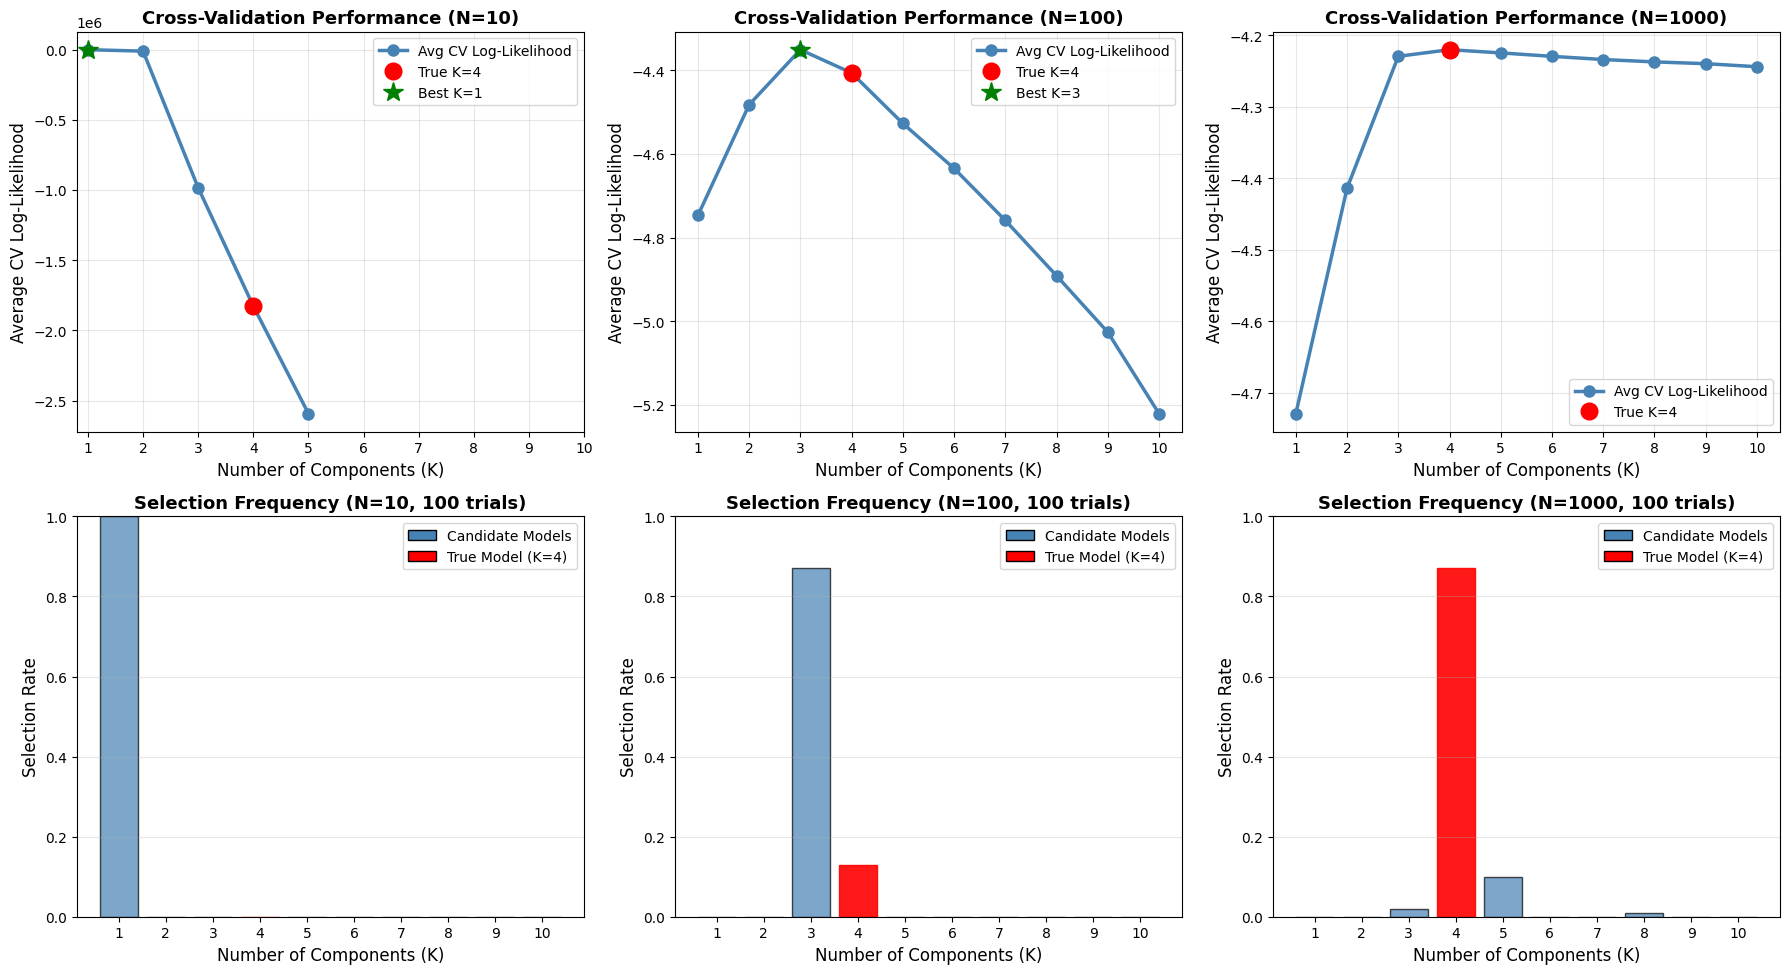

In [ ]:
# @title 4.4 Visualization

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, n in enumerate(dataset_sizes):
  # log-Likelihood curves
  ax_ll = axes[0, idx]
  avg_lls = cumulative_log_likelihoods[n] / n_trials

  ax_ll.plot(component_candidates, avg_lls, 'o-',
             color='steelblue', linewidth=2.5, markersize=8,
             label='Avg CV Log-Likelihood')

  # highlight true K=4
  true_k_idx = component_candidates.index(4)
  ax_ll.plot(component_candidates[true_k_idx], avg_lls[true_k_idx],
             'ro', markersize=12, label='True K=4', zorder=5)

  # mark the selected best K
  best_k_idx = np.argmax(avg_lls)
  if best_k_idx != true_k_idx:
    ax_ll.plot(component_candidates[best_k_idx], avg_lls[best_k_idx],
               'g*', markersize=15, label=f'Best K={component_candidates[best_k_idx]}', zorder=5)

  ax_ll.set_xlabel('Number of Components (K)', fontsize=12)
  ax_ll.set_ylabel('Average CV Log-Likelihood', fontsize=12)
  ax_ll.set_title(f'Cross-Validation Performance (N={n})',
                  fontsize=13, fontweight='bold')
  ax_ll.set_xticks(component_candidates)
  ax_ll.grid(True, alpha=0.3)
  ax_ll.legend(fontsize=10)

  # selection rate bars
  ax_bar = axes[1, idx]

  bars = ax_bar.bar(
    component_candidates,
    selection_rates[n],
    color='steelblue',
    edgecolor='black',
    alpha=0.7
  )

  # highlight true K=4
  bars[true_k_idx].set_color('red')
  bars[true_k_idx].set_alpha(0.9)

  ax_bar.set_xlabel('Number of Components (K)', fontsize=12)
  ax_bar.set_ylabel('Selection Rate', fontsize=12)
  ax_bar.set_title(f'Selection Frequency (N={n}, {n_trials} trials)',
                   fontsize=13, fontweight='bold')
  ax_bar.set_xticks(component_candidates)
  ax_bar.set_ylim([0, 1.0])
  ax_bar.grid(axis='y', alpha=0.3)

  legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', label='Candidate Models'),
    Patch(facecolor='red', edgecolor='black', label='True Model (K=4)')
  ]
  ax_bar.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()